In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
from scipy.stats import spearmanr, linregress
import matplotlib.pyplot as plt
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts
import EpiClockNBL.Select_fCpGs.util as local_util
import re
import matplotlib.patches as mpatches
import EpiClockNBL.src.maxima as maxima

In [8]:
# Output directories

proj_dir = os.path.join(pc_consts['official_indir_test'], 'TARGET')

figure_outdir = 'figures_traditional'
output_dir = 'outputs_traditional'
outfile_dir = os.path.join(output_dir, 'outfiles')
outdir = proj_dir

os.makedirs(figure_outdir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(outfile_dir, exist_ok=True)
os.makedirs(outdir, exist_ok=True)

In [3]:
###############################
##### IMPORT/PROCESS DATA #####
###############################

# Import beta values
beta_values_unbiased_sites = pd.read_table(
    os.path.join(proj_dir, 'beta_values_unbiased_sites.txt'),
    index_col=0
)
beta_values_unbiased_sites = beta_values_unbiased_sites.rename(columns=pc_util.getSampleID)

balanced_CpGs = beta_values_unbiased_sites.index.values
print(f'Starting with {balanced_CpGs.shape[0]} balanced sites')

Starting with 42473 balanced sites


In [4]:
# Import clinical table
clinical = pd.read_table(
#     index_col='submitter_id',    # not sure why this won't work -- might be because of quotes - output of R write.table
    os.path.join(proj_dir, 'cohort1.clinical.tsv')
)
clinical = clinical.set_index('submitter_id')

sampleIDs = beta_values_unbiased_sites.columns.values
patient_to_sample_IDs = pd.Series(data=sampleIDs, index=[pc_util.sampleToPatientID(x) for x in sampleIDs]).rename('sampleID')
clinical = clinical.merge(patient_to_sample_IDs, left_index=True, right_index=True, how='left')

In [5]:
# Remove sites that correlate with patient age

assert np.all((clinical['age_at_diagnosis'] + clinical['days_to_birth']).dropna() == 0)

spear_absCorr_list = []
patientID_list = beta_values_unbiased_sites.columns.map(pc_util.sampleToPatientID)
age_ser = clinical.loc[patientID_list, ['sampleID', 'age_at_diagnosis']].set_index('sampleID').squeeze('columns')
i = 0
for site in beta_values_unbiased_sites.index:
    if i % 10000 == 0:
        print(i)
    i += 1
    spear_absCorr_list.append(
        abs(
            spearmanr(
                pd.concat([beta_values_unbiased_sites.loc[site], age_ser], axis=1).dropna()
            ).correlation
        )
    )

spear_absCorr_ser = pd.Series(index=beta_values_unbiased_sites.index, data=spear_absCorr_list)

0
10000
20000
30000
40000


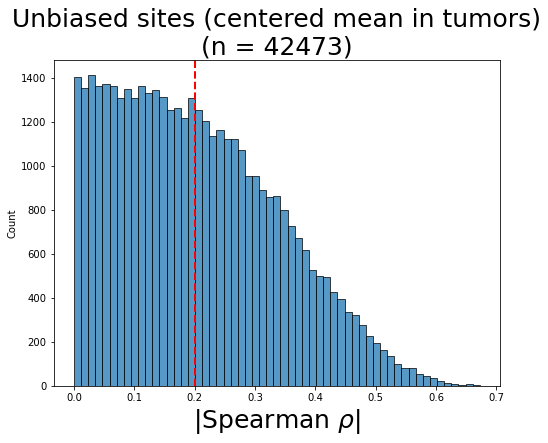

In [6]:
sf = 1

num_sites = len(spear_absCorr_ser)

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(spear_absCorr_ser)

ax.set_xlabel(r'|Spearman $\rho$|', fontsize=pc_consts['labelfontsize']*sf)
ax.set_title(f'Unbiased sites (centered mean in tumors)\n(n = {num_sites})', fontsize=pc_consts['labelfontsize']*sf)

ax.axvline(x=0.2, color='red', linestyle='--', linewidth=2)

plt.show()

# Need to investigate this in other cancers

### Remove correlating sites

In [7]:
nonCorrelating_sites = spear_absCorr_ser.index[spear_absCorr_ser < 0.2]
beta_values_unbiased_sites = beta_values_unbiased_sites.loc[nonCorrelating_sites]

## Rest of selection process

In [10]:
# Ideally, 1000 Clock sites selected
# We dont want to select more than half the number of unbiased sites (n)
# If n/2 < 1000, only pick n/2 sites
target_n = min(1000, int(balanced_CpGs.shape[0] / 2))
print(f'Picking {target_n} target sites')


########################
##### SELECT SITES #####
########################

# Fill missing values with mean of that site across tumors
km_beta_values = beta_values_unbiased_sites.apply(lambda x:x.fillna(x.mean()), axis=1)

# Determine clustering weights
# See local_util for details
clustering_weights_list = [local_util.clusteringWeights(km_beta_values, random_state=0) for i in range(50)]
clustering_weights_ser = pd.concat(clustering_weights_list, axis=1).mean(axis=1)

# Calculate inter-tumor stdevs of sites
balanced_beta_stdevs = beta_values_unbiased_sites.std(axis=1).dropna()

# Pick the most variable sites
Clock_CpGs = balanced_beta_stdevs.sort_values(ascending=False).index.values[:target_n]

# Calculate c_beta using Clock sites
c_beta = 1 - beta_values_unbiased_sites.loc[Clock_CpGs].std(axis=0)

########################
###### SAVE FILES ######
########################

## Save Clock CpG list
Clock_CpGs_filepath = os.path.join(output_dir, f'NBL_Clock_CpGs.txt')

# Save Clock sites, don't overwrite existing file
if os.path.exists(Clock_CpGs_filepath):
    existing_set = np.loadtxt(Clock_CpGs_filepath, dtype=str)
    assert np.all(np.sort(Clock_CpGs) == np.sort(existing_set))
    print('Current output matches existing file.')
else:
    np.savetxt(Clock_CpGs_filepath, Clock_CpGs, fmt='%s')

## Save c_beta values of final tumors
c_beta_final_samples = c_beta
c_beta_filepath = os.path.join(output_dir, f'NBL.c_beta.txt')

# Save c_beta values, don't overwrite existing file
if os.path.exists(c_beta_filepath):
    existing_c_beta = pd.read_table(c_beta_filepath, index_col=0, header=None).squeeze("columns")
    assert (c_beta_final_samples - existing_c_beta < 1e-6).all()
    print('Current output matches existing file.')
else:
    c_beta_final_samples.to_csv(c_beta_filepath, sep='\t', header=False)

# Save beta values of Clock sites
outfile_path = os.path.join(outdir, f'NBL.methyl.traditional_sites.tsv')
beta_values_unbiased_sites.loc[Clock_CpGs].to_csv(outfile_path, sep='\t')

Picking 1000 target sites


## Examine K-Means/PCA

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

km_beta_values = beta_values_unbiased_sites.apply(lambda x:x.fillna(x.mean()), axis=1)
km = KMeans(n_clusters=4, random_state=None).fit(km_beta_values.T)

In [90]:
def coloredPCA(col, use_groups=None, figsize=(6, 5), sites=None, ax=ax):
    if sites is None:
        sites = km_beta_values.index
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    tumors_transformed = PCA(2).fit_transform(km_beta_values.loc[sites].T)
    plot_data = pd.concat([pd.DataFrame(tumors_transformed, columns=['x', 'y']),
                       clinical.loc[km_beta_values.columns.map(pc_util.sampleToPatientID), col].reset_index()[col]
                      ], axis=1)
    if use_groups is not None:
        plot_data = plot_data.loc[plot_data[col].isin(use_groups)]
    sns.scatterplot(ax=ax, data=plot_data, x='x', y='y', hue=col)

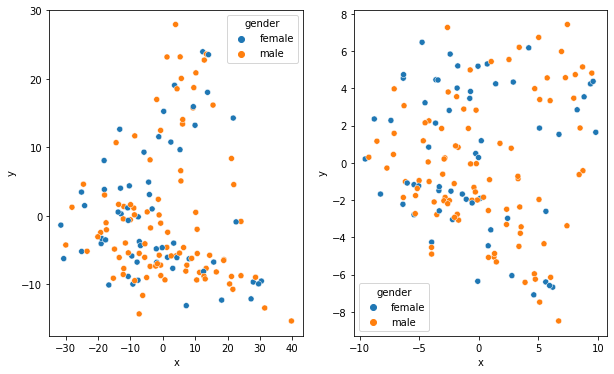

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
coloredPCA('gender', ax=axes[0])
coloredPCA('gender', ax=axes[1], sites=Clock_CpGs)

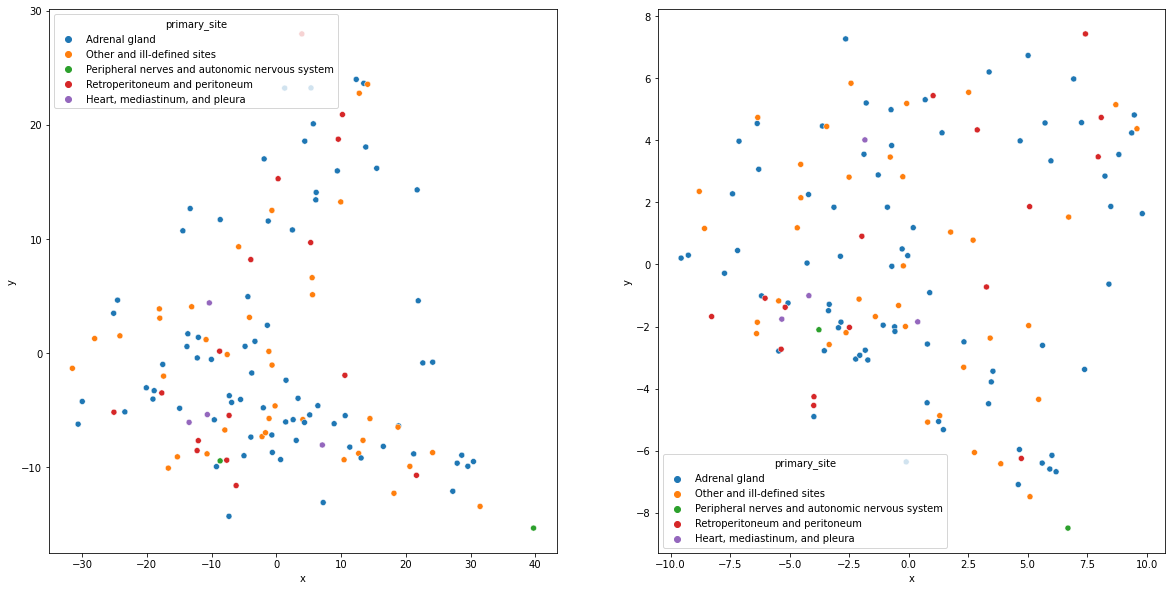

In [93]:
coloredPCA('primary_site', use_groups=clinical['primary_site'].value_counts().index[:5],
          figsize=(10, 10))

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
coloredPCA('primary_site', ax=axes[0], use_groups=clinical['primary_site'].value_counts().index[:5])
coloredPCA('primary_site', ax=axes[1], sites=Clock_CpGs, use_groups=clinical['primary_site'].value_counts().index[:5])

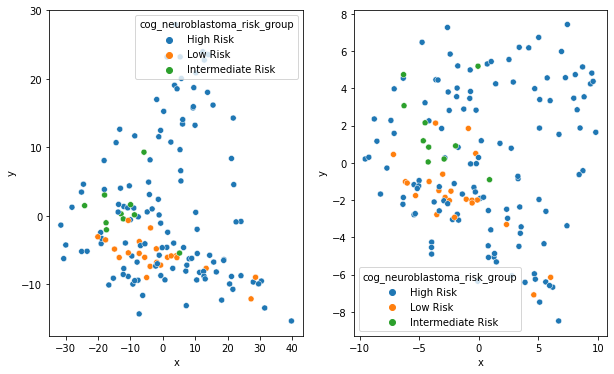

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
coloredPCA('cog_neuroblastoma_risk_group', ax=axes[0])
coloredPCA('cog_neuroblastoma_risk_group', ax=axes[1], sites=Clock_CpGs)

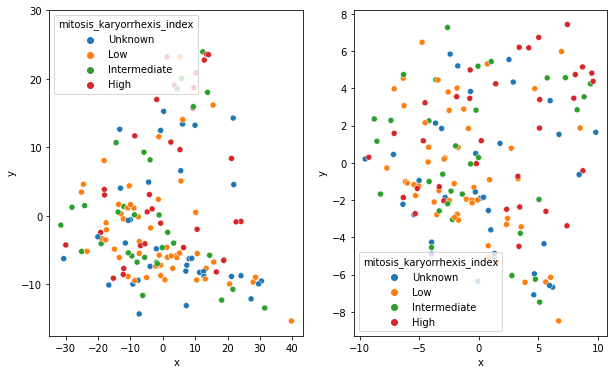

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
coloredPCA('mitosis_karyorrhexis_index', ax=axes[0])
coloredPCA('mitosis_karyorrhexis_index', ax=axes[1], sites=Clock_CpGs)

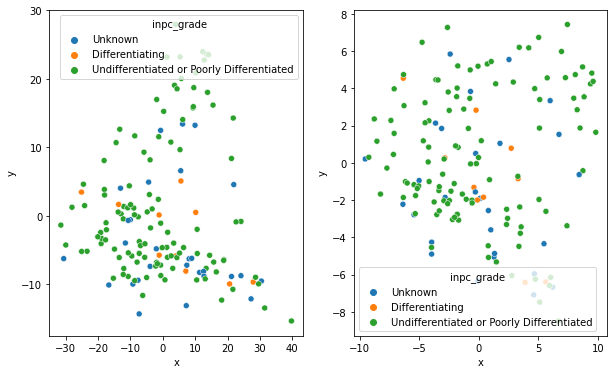

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
coloredPCA('inpc_grade', ax=axes[0])
coloredPCA('inpc_grade', ax=axes[1], sites=Clock_CpGs)

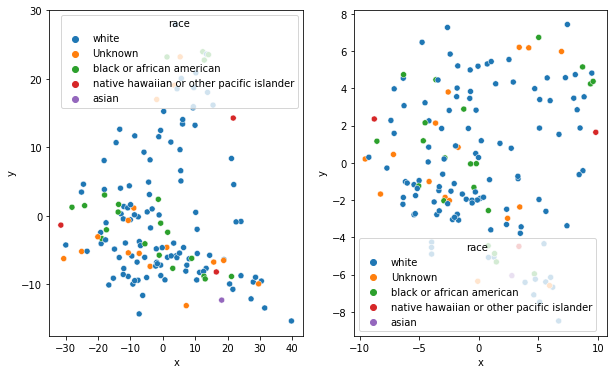

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
coloredPCA('race', ax=axes[0])
coloredPCA('race', ax=axes[1], sites=Clock_CpGs)

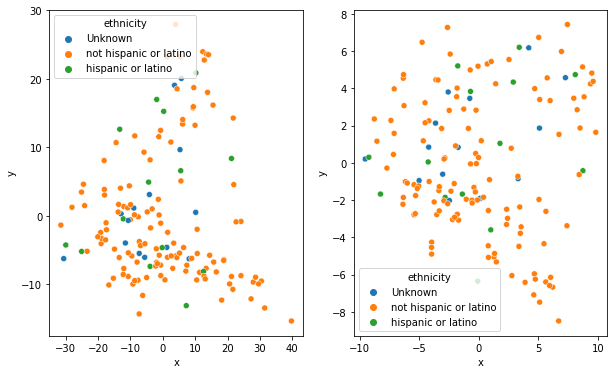

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
coloredPCA('ethnicity', ax=axes[0])
coloredPCA('ethnicity', ax=axes[1], sites=Clock_CpGs)

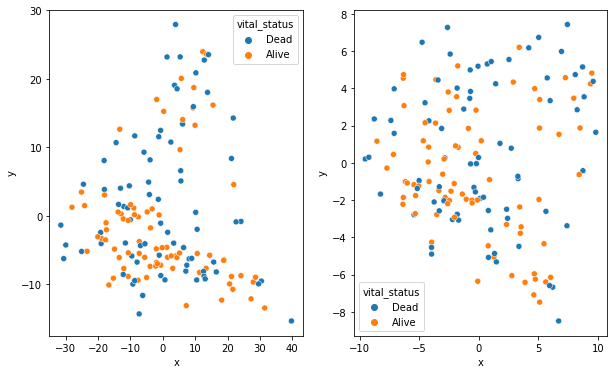

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
coloredPCA('vital_status', ax=axes[0])
coloredPCA('vital_status', ax=axes[1], sites=Clock_CpGs)

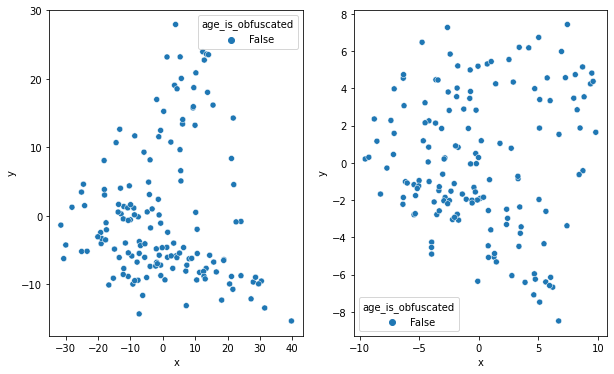

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
coloredPCA('age_is_obfuscated', ax=axes[0])
coloredPCA('age_is_obfuscated', ax=axes[1], sites=Clock_CpGs)

In [ ]:
# Calculate inter-tumor standard deviations of beta values

figsize = (7,5)

CpG_stdevs = beta_values_unbiased_sites.std(axis=1)

display(CpG_stdevs)

# Dataframe
# Column 1: inter-tumor stdev of that CpG
# Column 2: True iff CpG is in the Clock set
plot_data = pd.DataFrame({'CpG Stdevs':CpG_stdevs, 'Clock Set':CpG_stdevs.index.isin(Clock_CpGs)})

n_Clock = Clock_CpGs.shape[0]
n_not_Clock = CpG_stdevs.shape[0] - n_Clock

# Replace boolean column with a string column (with the following labels)
label_Clock = 'In $\mathcal{C}$' + f' (n = {n_Clock})'
label_not_Clock = 'Not in $\mathcal{C}$' + f' (n = {n_not_Clock})'
plot_data['Clock Set'] = plot_data['Clock Set'].map({True:label_Clock, False:label_not_Clock})
plot_data = plot_data.rename(columns={'Clock Set':'Type'})

# Colors for plot
color_dict = {label_Clock:pc_consts['palette_jco'][0],
              label_not_Clock:pc_consts['palette_jco'][2]}

# Create plot
fig, ax = plt.subplots(figsize=figsize * sf)
sns.histplot(ax=ax, data=plot_data, x='CpG Stdevs', hue='Type', stat='proportion', common_norm=False, bins=100,
             palette=color_dict, legend=False, alpha=pc_consts['opacity'])

# Customize figure
ax.set_xlabel('Standard deviation of β', fontsize=pc_consts['labelfontsize'] * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=pc_consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Legend
patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(plots_x, plots_y + .005),
           fontsize=0.8 * pc_consts['labelfontsize'] * sf
          )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'Lund_Validate.pdf'), format='pdf', pad_inches=0.1)

# Calculate medians of both groups and Wilcoxon rank-sums test p-value
# print(f'n = {len(useSamples)}')
vals_Clock = plot_data.loc[plot_data['Type'] == label_Clock, 'CpG Stdevs']
vals_not_Clock = plot_data.loc[plot_data['Type'] == label_not_Clock, 'CpG Stdevs']
# pvalue = epi_util.wilcoxonRankSums(vals_Clock, vals_not_Clock).pvalue

print(f'Clock sites median: {vals_Clock.median():.3f}')
print(f'Non-clock sites median: {vals_not_Clock.median():.3f}')
# print(f'Wilcoxon rank-sum test: P = {pvalue:.0e}')

In [ ]:
# Dataframe
# Column 1: inter-tumor stdev of that CpG
# Column 2: True iff CpG is in the Clock set
plot_data = pd.DataFrame({'CpG Stdev Means':CpG_stdev_means, 'Clock Set':CpG_stdev_means.index.isin(Clock_CpGs)})

n_Clock = Clock_CpGs.shape[0]
n_not_Clock = CpG_stdev_means.shape[0] - n_Clock

# Replace boolean column with a string column (with the following labels)
label_Clock = 'In $\mathcal{C}$' + f' (n = {n_Clock})'
label_not_Clock = 'Not in $\mathcal{C}$' + f' (n = {n_not_Clock})'
plot_data['Clock Set'] = plot_data['Clock Set'].map({True:label_Clock, False:label_not_Clock})
plot_data = plot_data.rename(columns={'Clock Set':'Type'})

# Colors for plot
color_dict = {label_Clock:consts['palette_jco'][0],
              label_not_Clock:consts['palette_jco'][2]}

# Create plot
fig, ax = plt.subplots(1, 1, figsize=figsize * sf)
sns.histplot(ax=ax, data=plot_data, x='CpG Stdev Means', hue='Type', stat='proportion', common_norm=False, bins=100, palette=color_dict,
                   legend=False, alpha=consts['opacity'])

# Customize figure
ax.set_xlabel('Mean intra-tumor standard deviation of β', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Create legend
patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(plots_x, plots_y + .005),
           fontsize=0.8 * consts['labelfontsize'] * sf
          )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'Luo_Validate.pdf'), format='pdf', pad_inches=0.1)

# Calculate medians of both groups and Wilcoxon rank-sums test p-value
vals_Clock = plot_data.loc[plot_data['Type'] == label_Clock, 'CpG Stdev Means']
vals_not_Clock = plot_data.loc[plot_data['Type'] == label_not_Clock, 'CpG Stdev Means']
pvalue = epi_util.wilcoxonRankSums(vals_Clock, vals_not_Clock).pvalue

print(f'Clock sites median: {vals_Clock.median():.3f}')
print(f'Non-clock sites median: {vals_not_Clock.median():.3f}')
print(f'Wilcoxon rank-sum test: P = {pvalue:.0e}')